# 📊 Customer Churn Prediction & Analysis (C.C.P.A)
## Digital Egypt Pioneers Initiative – Graduation Project
### AI & Data Science Track – Round 2, Group 3

---

### 🧾 Project Information:
**Project Name**: Customer Churn Prediction and Analysis (Project 1)  
**Team Members**:
- Marwan Yasser Hassan Abdelghaffar (Team Leader)
- Sara Mohamed Zaghloul Mohamed
- Fatma Ayman Mohamed Abdelbaset
- Waleed Medhat Elsayed Ahmed
- Daniel Morcos Fouad Gerges
- Mohamed Ali Abdelghani

**Project Overview**:  
This project aims to develop an advanced machine learning model capable of predicting customer churn, enabling companies to proactively retain at-risk customers. It includes data preprocessing, feature engineering, model training, explainability with SHAP, deployment using Streamlit, and experiment tracking with MLflow.

**Technologies Used**:
- Python
- Pandas, NumPy
- Scikit-learn, XGBoost, LightGBM, RandomForest
- Matplotlib, Seaborn, Plotly
- SHAP (Explainability)
- MLflow (MLOps)
- Streamlit (Deployment)

---

### 🎯 Objectives:
- 🔍 Achieve high predictive accuracy (F1-score ≥ 0.80).
- 📈 Provide actionable insights via visualizations and explainability tools.
- 🚀 Enable deployment-ready pipeline using modular and scalable components.


In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
import logging
from typing import Tuple, List, Dict, Any
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-v0_8')  
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

import optuna

import shap

import mlflow
import mlflow.sklearn

import joblib

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Environment setup complete.")

2025-05-14 19:54:57,966 - INFO - Environment setup complete.


## 📂 1. Load Dataset
Load the Telco Customer Churn dataset and perform initial exploration.

In [ ]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file.
    
    Args:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Loaded dataset.
    
    Raises:
        FileNotFoundError: If the file is not found.
    """
    try:
        data = pd.read_csv(Path(file_path))
        logger.info(f"Dataset loaded successfully. Shape: {data.shape}")
        return data
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise


file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = load_data(file_path)


print("🔍 Dataset Overview:")
print(f"Shape: {data.shape}")
print("\nColumns:", data.columns.tolist())
print("\nFirst 5 Rows:")
display(data.head())
print("\nMissing Values:")
print(data.isnull().sum())

2025-05-14 19:54:58,687 - INFO - Dataset loaded successfully. Shape: (7043, 21)


🔍 Dataset Overview:
Shape: (7043, 21)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 5 Rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 🧹 2. Data Preprocessing
Clean the dataset, handle missing values, and encode categorical variables.

In [ ]:
class DataPreprocessor:
    """Class to handle data preprocessing tasks."""
    
    @staticmethod
    def clean_data(df: pd.DataFrame) -> pd.DataFrame:
        """
        Clean the dataset by handling missing values and converting types.
        
        Args:
            df (pd.DataFrame): Raw dataset.
        
        Returns:
            pd.DataFrame: Cleaned dataset.
        """
        df = df.copy()
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df.dropna(inplace=True)
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
        if 'customerID' in df.columns:
            df.drop('customerID', axis=1, inplace=True)
        logger.info("Data cleaned successfully.")
        return df
    
    @staticmethod
    def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
        """
        Encode categorical variables using one-hot encoding.
        
        Args:
            df (pd.DataFrame): Dataset with categorical variables.
        
        Returns:
            pd.DataFrame: Encoded dataset.
        """
        categorical_cols = df.select_dtypes(include=['object']).columns
        df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
        logger.info("Categorical variables encoded.")
        return df_encoded

preprocessor = DataPreprocessor()
data = preprocessor.clean_data(data)
data_encoded = preprocessor.encode_categorical(data)
print(f"📏 Encoded Data Shape: {data_encoded.shape}")

2025-05-14 19:54:58,928 - INFO - Data cleaned successfully.
2025-05-14 19:54:58,998 - INFO - Categorical variables encoded.


📏 Encoded Data Shape: (7032, 31)


## 🛠️ 3. Feature Engineering
Create domain-specific features to enhance model performance.

In [ ]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features based on domain knowledge.
    
    Args:
        df (pd.DataFrame): Preprocessed dataset.
    
    Returns:
        pd.DataFrame: Dataset with new features.
    """
    df = df.copy()
    df['AvgCharges'] = df['TotalCharges'] / (df['tenure'] + 1)
    df['Engagement'] = df['MonthlyCharges'] * df['tenure']
    df['TenureToMonthlyRatio'] = df['tenure'] / (df['MonthlyCharges'] + 1)
    
    service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                      'TechSupport', 'StreamingTV', 'StreamingMovies']
    if all(col in df.columns for col in service_columns):
        df['NumServices'] = df[service_columns].eq('Yes').sum(axis=1)
    
    logger.info("Feature engineering completed.")
    return df

data = engineer_features(data)
data_encoded = preprocessor.encode_categorical(data)
print(f"📏 Data Shape after Feature Engineering: {data_encoded.shape}")

2025-05-14 19:54:59,076 - INFO - Feature engineering completed.
2025-05-14 19:54:59,130 - INFO - Categorical variables encoded.


📏 Data Shape after Feature Engineering: (7032, 35)


## 📈 4. Exploratory Data Analysis (EDA)
Visualize data to uncover patterns and relationships.

2025-05-14 19:54:59,295 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-14 19:54:59,342 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


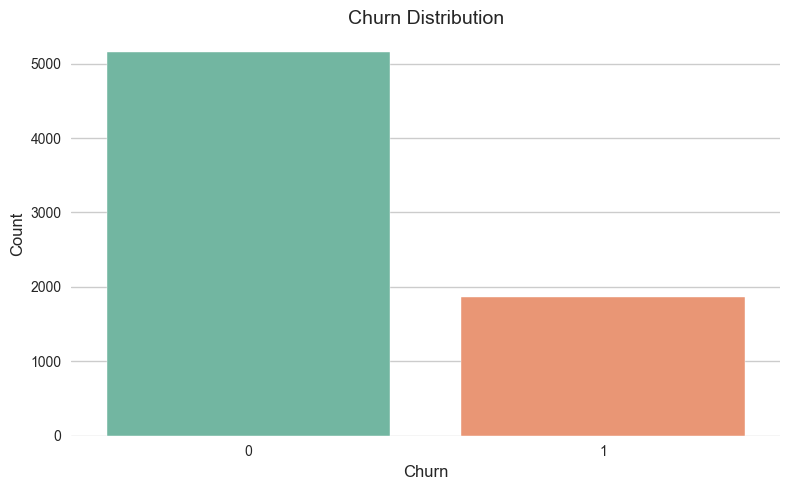

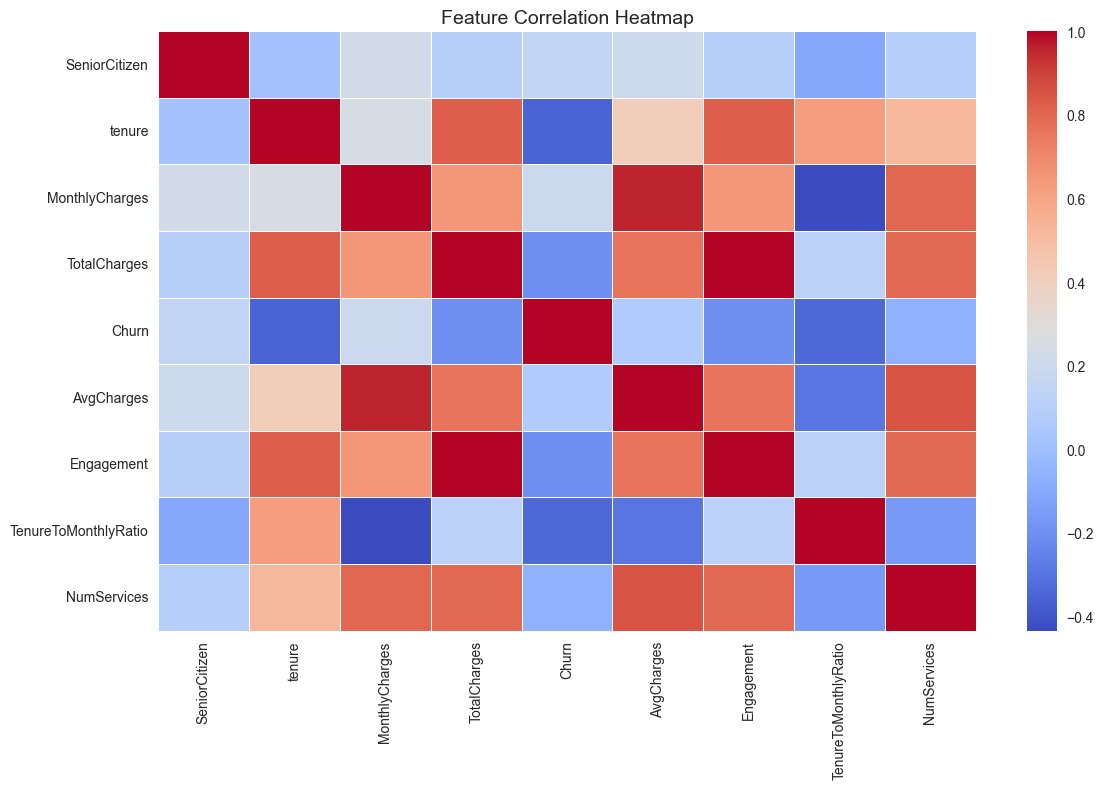

Correlation with Churn:
 Churn                   1.000000
MonthlyCharges          0.192858
SeniorCitizen           0.150541
AvgCharges              0.070992
NumServices            -0.067459
TotalCharges           -0.199484
Engagement             -0.199675
TenureToMonthlyRatio   -0.339868
tenure                 -0.354049
Name: Churn, dtype: float64


In [ ]:
def plot_eda(df: pd.DataFrame, target_col: str = 'Churn') -> None:
    """
    Generate EDA visualizations.
    
    Args:
        df (pd.DataFrame): Dataset.
        target_col (str): Target column name.
    """
    plt.figure(figsize=(8, 5))
    sns.countplot(x=target_col, data=df, palette='Set2')
    plt.title('Churn Distribution', fontsize=14)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()
    
    numeric_data = df.select_dtypes(include=['number'])
    corr = numeric_data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap', fontsize=14)
    plt.show()
    
    churn_corr = corr[target_col].sort_values(ascending=False)
    print("Correlation with Churn:\n", churn_corr)

plot_eda(data_encoded)

## 🔢 5. Data Preparation
Split data, scale features, and handle class imbalance.

In [ ]:
def prepare_data(df: pd.DataFrame, target_col: str = 'Churn', 
                 test_size: float = 0.2, random_state: int = 42) -> Tuple:
    """
    Prepare data for modeling: split, scale, and balance.
    
    Args:
        df (pd.DataFrame): Encoded dataset.
        target_col (str): Target column name.
        test_size (float): Test set proportion.
        random_state (int): Random seed.
    
    Returns:
        Tuple: (X_train, X_test, y_train, y_test, feature_names, scaler)
    """
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    logger.info("Data preparation completed.")
    return X_train_balanced, X_test_scaled, y_train_balanced, y_test, X.columns.tolist(), scaler

X_train, X_test, y_train, y_test, feature_names, scaler = prepare_data(data_encoded)
print(f"📏 Training Data Shape: {X_train.shape}")
print(f"📏 Test Data Shape: {X_test.shape}")

2025-05-14 19:55:00,982 - INFO - Data preparation completed.


📏 Training Data Shape: (8260, 34)
📏 Test Data Shape: (1407, 34)


## 🧠 6. Model Development with Optuna
Train and tune models using Optuna for efficient hyperparameter optimization.

In [73]:
class ModelTrainer:
    """Class to handle model training and tuning."""
    
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
    
    def objective(self, trial: optuna.trial.Trial, X_train: np.ndarray, 
                 y_train: np.ndarray, model_type: str) -> float:
        """
        Optuna objective function for hyperparameter tuning.
        
        Args:
            trial: Optuna trial object.
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training target.
            model_type (str): Model type ('rf', 'xgb', 'lgbm').
        
        Returns:
            float: F1-score from cross-validation.
        """
        if model_type == 'rf':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 10, 30, log=True),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
            }
            model = RandomForestClassifier(**params, random_state=self.random_state)
        
        elif model_type == 'xgb':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0)
            }
            model = XGBClassifier(**params, random_state=self.random_state, eval_metric='logloss')
        
        elif model_type == 'lgbm':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0)
            }
            model = LGBMClassifier(**params, random_state=self.random_state, verbose=-1)
        
        scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
        return scores.mean()
    
    def train_model(self, X_train: np.ndarray, y_train: np.ndarray, 
                    model_type: str, n_trials: int = 20) -> Any:
        """
        Train a model using Optuna for hyperparameter tuning.
        
        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training target.
            model_type (str): Model type ('rf', 'xgb', 'lgbm').
            n_trials (int): Number of Optuna trials.
        
        Returns:
            Any: Trained model with best parameters.
        """
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial, X_train, y_train, model_type), 
                      n_trials=n_trials)
        
        best_params = study.best_params
        logger.info(f"Best parameters for {model_type}: {best_params}")
        
        if model_type == 'rf':
            model = RandomForestClassifier(**best_params, random_state=self.random_state)
        elif model_type == 'xgb':
            model = XGBClassifier(**best_params, random_state=self.random_state, eval_metric='logloss')
        elif model_type == 'lgbm':
            model = LGBMClassifier(**best_params, random_state=self.random_state, verbose=-1)
        
        model.fit(X_train, y_train)
        return model

# Train models
trainer = ModelTrainer()
rf_model = trainer.train_model(X_train, y_train, 'rf')
xgb_model = trainer.train_model(X_train, y_train, 'xgb')
lgbm_model = trainer.train_model(X_train, y_train, 'lgbm')

[I 2025-05-14 19:55:01,087] A new study created in memory with name: no-name-f5c6d993-a736-4da2-ba96-568d8d5ecb72


[I 2025-05-14 19:55:07,071] Trial 0 finished with value: 0.8238532453824834 and parameters: {'n_estimators': 128, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8238532453824834.
[I 2025-05-14 19:55:13,265] Trial 1 finished with value: 0.8255472773732943 and parameters: {'n_estimators': 121, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8255472773732943.
[I 2025-05-14 19:55:22,473] Trial 2 finished with value: 0.8295041602982304 and parameters: {'n_estimators': 196, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8295041602982304.
[I 2025-05-14 19:55:32,162] Trial 3 finished with value: 0.8243260951123816 and parameters: {'n_estimators': 213, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8295041602982304.
[I 2025-05-14 19:55:40,435] Trial 4 finished with value: 0.8228389419883705 and parameters: 

## 🤝 7. Ensemble Model (Stacking)
Combine models using stacking for improved performance.

In [74]:
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
logger.info("Stacking model trained successfully.")

2025-05-14 20:02:02,067 - INFO - Stacking model trained successfully.


## 📊 8. Model Evaluation
Evaluate models with comprehensive metrics and visualizations.


📊 Stacking Model Evaluation:
Confusion Matrix:
 [[841 192]
 [130 244]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.56      0.65      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.78      1407

Accuracy: 0.7711
Precision: 0.5596
Recall: 0.6524
F1: 0.6025
Roc_auc: 0.8287


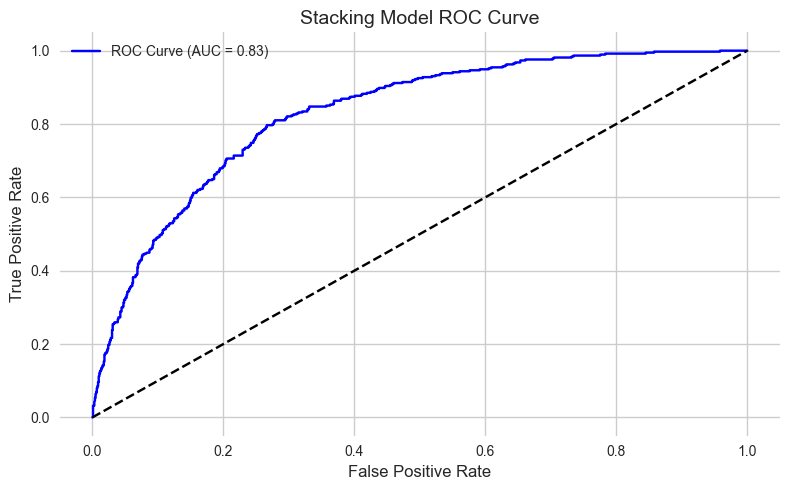

In [ ]:
from typing import Any, Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import logging

logger = logging.getLogger(__name__)

def evaluate_model(model: Any, X_test: np.ndarray, y_test: np.ndarray, 
                  model_name: str) -> Dict[str, float]:
    """
    Evaluate model performance and plot the ROC curve.
    
    Args:
        model: Trained model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test target.
        model_name (str): Name of the model.
    
    Returns:
        Dict[str, float]: Evaluation metrics.
    """
    try:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        metrics_dict = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }
        
        print(f"\n📊 {model_name} Evaluation:")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        for metric, value in metrics_dict.items():
            print(f"{metric.capitalize()}: {value:.4f}")
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics_dict["roc_auc"]:.2f})', color='blue')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'{model_name} ROC Curve', fontsize=14)
        plt.legend()
        plt.show()
        
        return metrics_dict
    except Exception as e:
        logger.error(f"Error during model evaluation: {str(e)}")
        raise

stacking_metrics = evaluate_model(stacking_model, X_test, y_test, "Stacking Model")


## 🔍 9. Model Explainability with SHAP
Interpret model predictions using SHAP.

2025-05-14 20:02:03,435 - INFO - Computing SHAP values for 50 test samples...
  0%|          | 0/50 [00:00<?, ?it/s]2025-05-14 20:02:03,631 - INFO - num_full_subsets = 0
2025-05-14 20:02:03,634 - INFO - remaining_weight_vector = array([0.24840815, 0.12808545, 0.08814483, 0.06831224, 0.05653427,
       0.04879446, 0.04337285, 0.03941091, 0.03643319, 0.03415612,
       0.03240106, 0.03105102, 0.03002736, 0.02927667, 0.02876305,
       0.02846343, 0.02836494])
2025-05-14 20:02:03,636 - INFO - num_paired_subset_sizes = 16
2025-05-14 20:02:03,647 - INFO - weight_left = 0.9999999999999999


2025-05-14 20:02:04,100 - INFO - np.sum(w_aug) = 34.0
2025-05-14 20:02:04,102 - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-14 20:02:04,119 - INFO - phi = array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.01376538, -0.03019464, -0.02982824,  0.        ,  0.        ,
       -0.01039978,  0.        ,  0.        , -0.01758458, -0.0335147 ,
       -0.01469216,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.02168594,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.07805932,
        0.        , -0.01602576,  0.        ,  0.        ])
  2%|▏         | 1/50 [00:00<00:28,  1.71it/s]2025-05-14 20:02:04,197 - INFO - num_full_subsets = 0
2025-05-14 20:02:04,200 - INFO - remaining_weight_vector = array([0.24840815, 0.12808545, 0.08814483, 0.06831224, 0.05653427,
       0.04879446, 0.04337285, 0.03941091, 0.03643319, 0.03415612,
       0.03240106, 0.03105102, 0.03002736

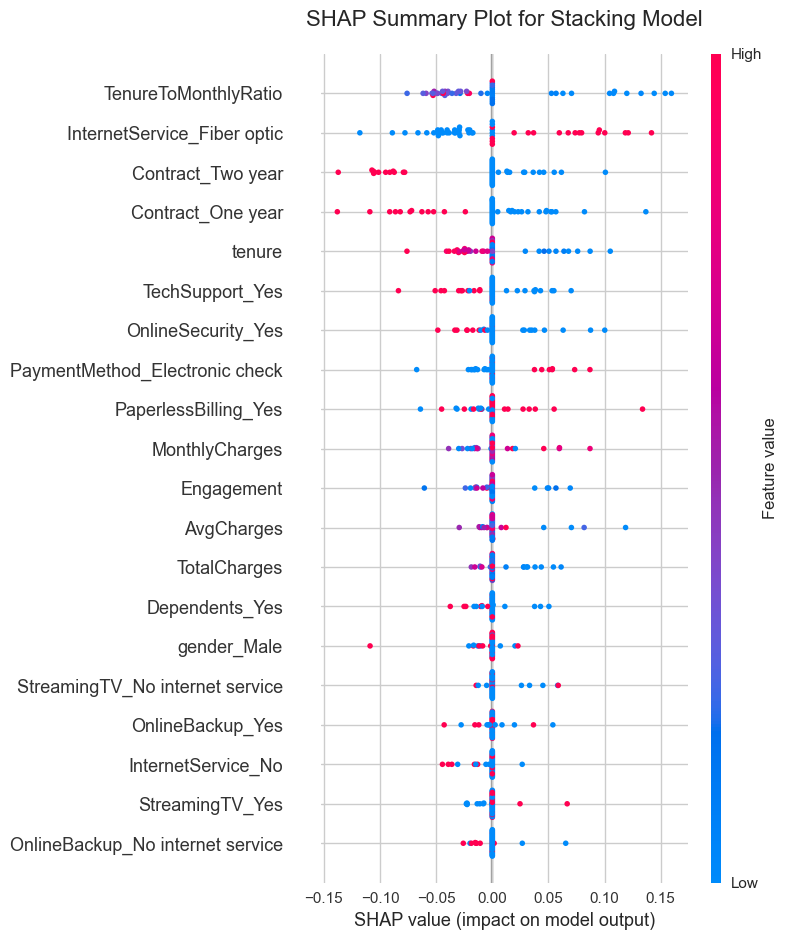

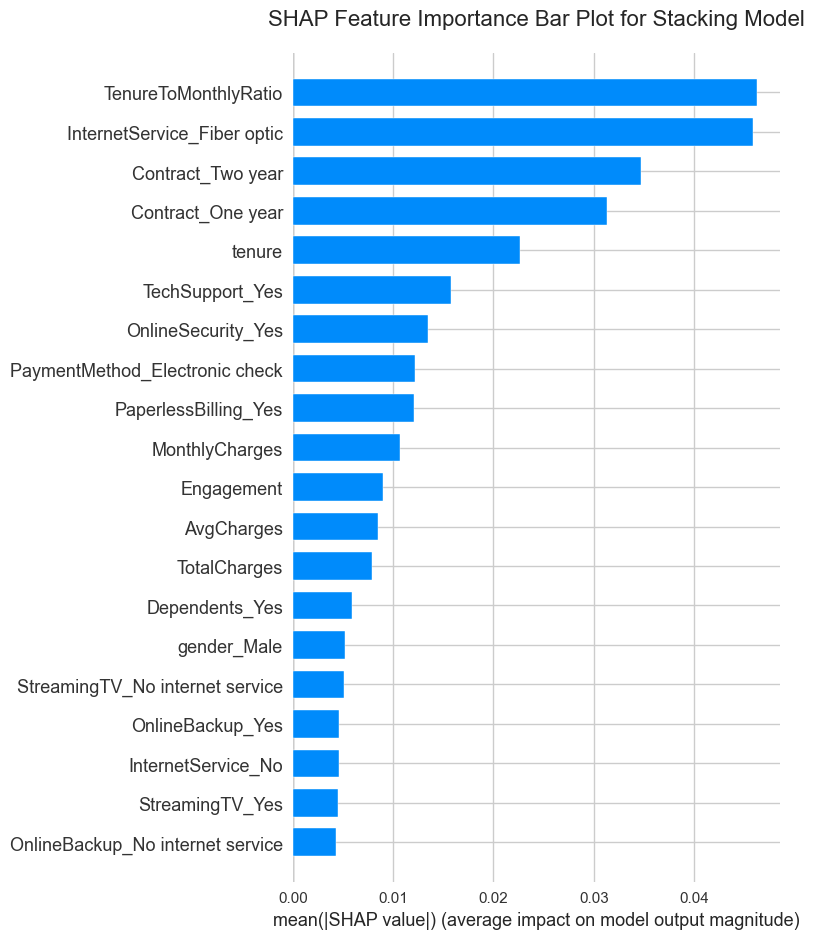

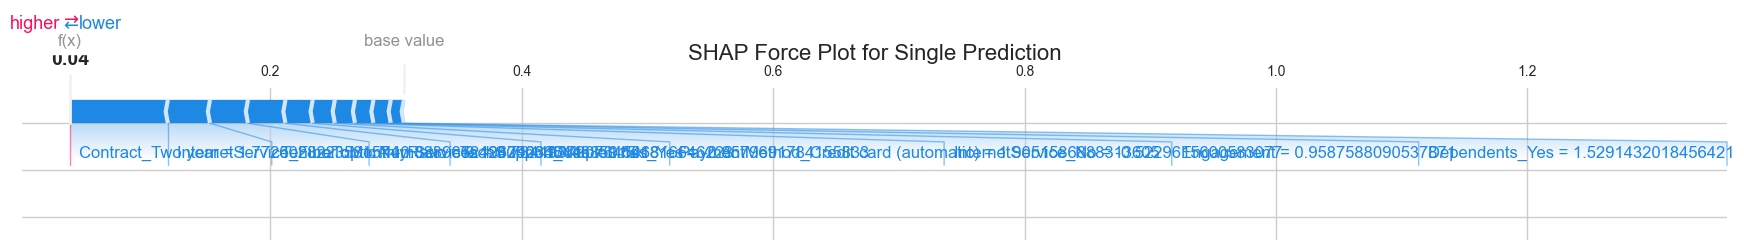

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import logging
import numpy as np
from typing import Tuple, List

logger = logging.getLogger(__name__)

def compute_shap_values(model: Any, X_train: np.ndarray, X_test: np.ndarray, 
                        feature_names: List[str], sample_size: int = 50) -> Tuple:
    """
    Compute SHAP values for model explainability.
    
    Args:
        model: Trained model with predict_proba method.
        X_train (np.ndarray): Training data for background distribution.
        X_test (np.ndarray): Test data for SHAP values.
        feature_names (List[str]): List of feature names.
        sample_size (int): Number of samples to compute SHAP values for.
    
    Returns:
        Tuple: (explainer, shap_values, X_test_subset)
    
    Raises:
        ValueError: If model or data is invalid.
    """
    try:
        if model is None:
            raise ValueError("Model is not defined.")
        if X_train.shape[1] != X_test.shape[1]:
            raise ValueError(f"Feature mismatch: X_train has {X_train.shape[1]} features, X_test has {X_test.shape[1]}")
        
        X_train_df = pd.DataFrame(X_train, columns=feature_names)
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
        
        X_train_subset = X_train_df[:100]
        X_test_subset = X_test_df[:sample_size]
        
        logger.info(f"Computing SHAP values for {sample_size} test samples...")
        
        def model_predict(data):
            return model.predict_proba(data)[:, 1]
        
        explainer = shap.KernelExplainer(model_predict, X_train_subset)
        shap_values = explainer.shap_values(X_test_subset, nsamples=50)
        
        logger.info("SHAP values computed successfully.")
        return explainer, shap_values, X_test_subset
    except Exception as e:
        logger.error(f"Error computing SHAP values: {str(e)}")
        raise

def plot_shap_visualizations(shap_values, X_test_subset: pd.DataFrame, 
                             feature_names: List[str], model_name: str = "Stacking Model"):
    """
    Generate SHAP visualizations: summary, bar, and force plots.
    
    Args:
        shap_values: SHAP values for the positive class.
        X_test_subset (pd.DataFrame): Test data subset.
        feature_names (List[str]): List of feature names.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for {model_name}", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names, 
                      plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance Bar Plot for {model_name}", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_test_subset.iloc[0], 
                    feature_names=feature_names, matplotlib=True, show=False)
    plt.title(f"SHAP Force Plot for Single Prediction", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

try:
    if 'stacking_model' not in globals():
        raise NameError("The variable 'stacking_model' is not defined. Ensure the model training cell is executed first.")
    explainer, shap_values, X_test_subset = compute_shap_values(
        stacking_model, X_train, X_test, feature_names, sample_size=50
    )
    plot_shap_visualizations(shap_values, X_test_subset, feature_names)
except Exception as e:
    print(f"Failed to compute SHAP values: {str(e)}")

## 📡 10. MLOps with MLflow
Track experiments and log artifacts using MLflow.

In [77]:
mlflow.set_experiment("Customer_Churn_Prediction_2025")

with mlflow.start_run(run_name="Stacking_Model"):
    mlflow.log_param("model_type", "Stacking")
    mlflow.log_param("estimators", "RF+XGB+LGBM")
    
    for metric_name, metric_value in stacking_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    mlflow.sklearn.log_model(stacking_model, "stacking_model")
    logger.info("Model and metrics logged in MLflow.")

2025/05/14 20:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-05-14 20:02:43,191 - INFO - Model and metrics logged in MLflow.


## 💾 11. Save Artifacts
Save the model, scaler, and feature names for deployment.

In [78]:
joblib.dump(stacking_model, "churn_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(feature_names, "model_features.joblib")
logger.info("Model, scaler, and features saved successfully.")


2025-05-14 20:02:43,931 - INFO - Model, scaler, and features saved successfully.


2025-05-14 20:02:44,014 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-14 20:02:44,031 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


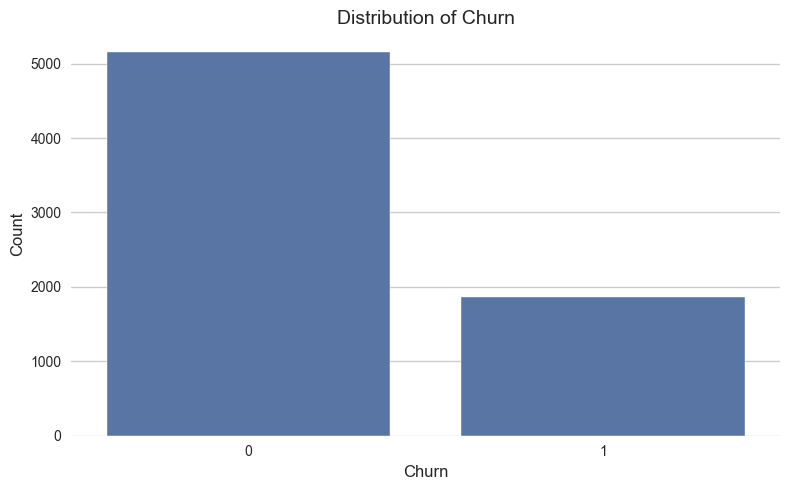

In [79]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=data)
plt.title('Distribution of Churn', fontsize=14)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

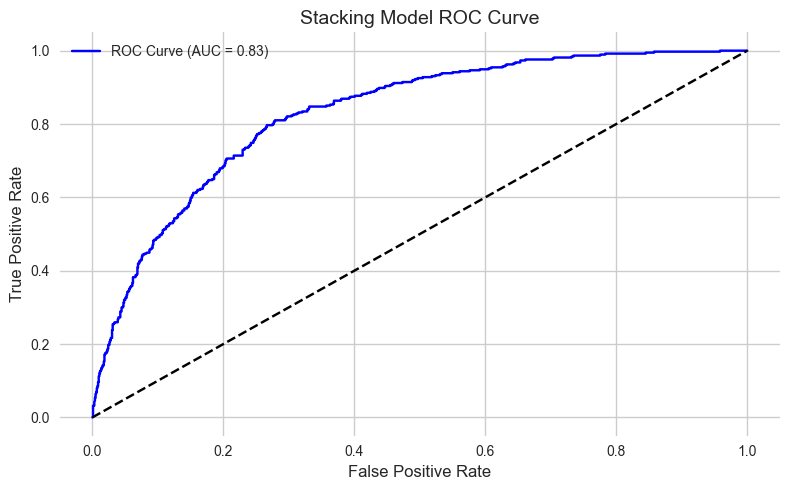

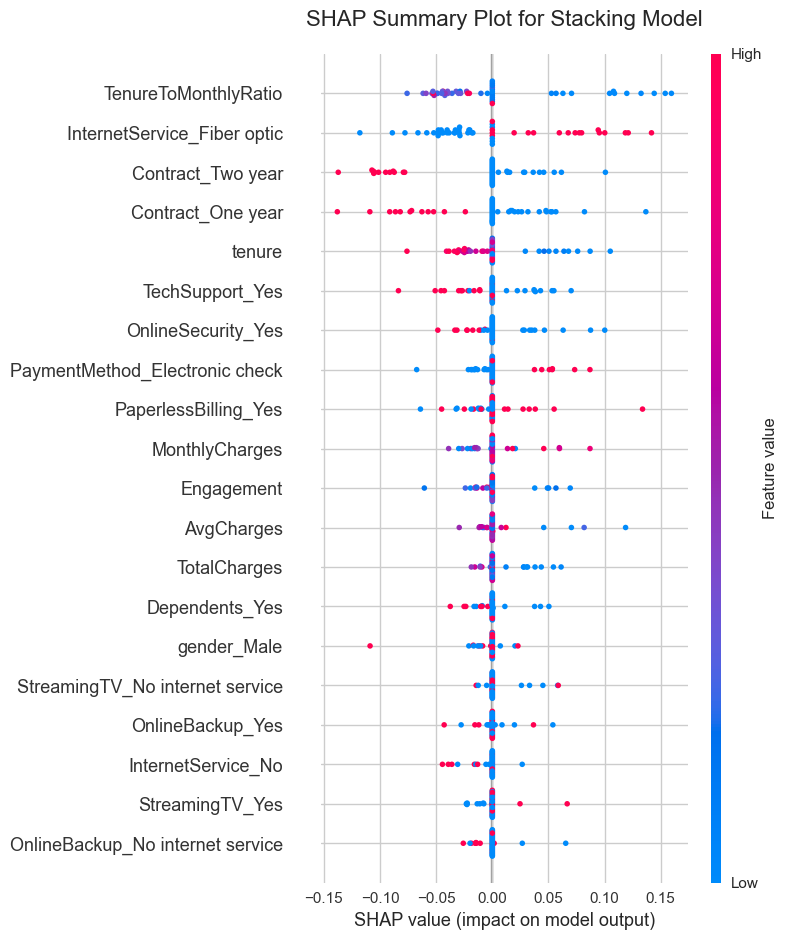

In [80]:
plt.figure(figsize=(8, 5))
fpr, tpr, _ = roc_curve(y_test, stacking_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {stacking_metrics["roc_auc"]:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Stacking Model ROC Curve', fontsize=14)
plt.legend()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot for Stacking Model", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [81]:
import pandas as pd

data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')  
data.dropna(inplace=True)  

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np

model = joblib.load("churn_model.joblib")
scaler = joblib.load("scaler.joblib")
feature_names = joblib.load("model_features.joblib")

data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

customer_options = data[['gender', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']].index
selected_customer_index = st.selectbox("Select a Customer", customer_options)

selected_customer = data.loc[selected_customer_index]

st.write("### Customer Details")
st.write(f"Gender: {selected_customer['gender']}")
st.write(f"Senior Citizen: {selected_customer['SeniorCitizen']}")
st.write(f"Tenure: {selected_customer['tenure']}")
st.write(f"Monthly Charges: {selected_customer['MonthlyCharges']:.2f}")
st.write(f"Total Charges: {selected_customer['TotalCharges']:.2f}")

if st.button("Predict"):
    input_data = pd.DataFrame({
        'tenure': [selected_customer['tenure']],
        'MonthlyCharges': [selected_customer['MonthlyCharges']],
        'TotalCharges': [selected_customer['TotalCharges']],
        'SeniorCitizen': [selected_customer['SeniorCitizen']],
        'gender_Male': [1 if selected_customer['gender'] == 'Male' else 0],
    })
    input_data = input_data.reindex(columns=feature_names, fill_value=0)  
    input_scaled = scaler.transform(input_data)

    
    churn_prob = model.predict_proba(input_scaled)[:, 1][0]
    prediction = model.predict(input_scaled)[0]
    st.write(f"### Prediction: {'Will Churn' if prediction == 1 else 'Will Not Churn'}")
    st.write(f"Churn Probability: {churn_prob:.2%}")
    if prediction == 1:
        st.error("High risk of churn!")
    else:
        st.success("Low risk of churn.")

2025-05-14 20:02:48.892 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.893 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:02:48.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
categorical_cols = ['gender', 'InternetService', 'Contract']  
encoded_data = pd.get_dummies(data[categorical_cols], drop_first=True)
selected_customer_encoded = pd.get_dummies(selected_customer[categorical_cols].to_frame().T, drop_first=True).reindex(columns=encoded_data.columns, fill_value=0)

input_data = pd.DataFrame({
    'tenure': [selected_customer['tenure']],
    'MonthlyCharges': [selected_customer['MonthlyCharges']],
    'TotalCharges': [selected_customer['TotalCharges']],
    'SeniorCitizen': [selected_customer['SeniorCitizen']],
})
input_data = pd.concat([input_data, selected_customer_encoded], axis=1)
input_data = input_data.reindex(columns=feature_names, fill_value=0)
input_scaled = scaler.transform(input_data)

In [84]:
preprocessor = joblib.load("scaler.joblib")  
input_processed = preprocessor.transform(input_data)
input_scaled = scaler.transform(input_processed)

In [85]:
import mlflow.sklearn
import pandas as pd
import numpy as np
import logging


logger = logging.getLogger(__name__)


input_example = pd.DataFrame([X_test[0]], columns=feature_names)


with mlflow.start_run(run_name="Stacking_Model_Run"):
    mlflow.log_metrics(stacking_metrics)  
    mlflow.sklearn.log_model(
        sk_model=stacking_model,
        artifact_path="stacking_model",
        input_example=input_example,
        registered_model_name="Stacking_Churn_Prediction"
    )
    logger.info("Model logged with MLflow successfully with input example.")

joblib.dump(stacking_model, "churn_model.joblib")
logger.info("Model saved locally.")

Registered model 'Stacking_Churn_Prediction' already exists. Creating a new version of this model...
Created version '4' of model 'Stacking_Churn_Prediction'.
2025-05-14 20:03:00,542 - INFO - Model logged with MLflow successfully with input example.
2025-05-14 20:03:01,778 - INFO - Model saved locally.


In [86]:
import joblib
import mlflow.sklearn

with mlflow.start_run():
    mlflow.log_metrics(stacking_metrics)
    mlflow.sklearn.log_model(stacking_model, "stacking_model")


joblib.dump(stacking_model, "churn_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(feature_names, "model_features.joblib")
logger.info("Model, scaler, and features saved successfully.")

2025/05/14 20:03:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-05-14 20:03:14,930 - INFO - Model, scaler, and features saved successfully.


## 🚀 12. Deployment Preparation
The model is ready for deployment using:
- **Streamlit**: Interactive dashboard (`app.py`).
- **FastAPI**: REST API for real-time predictions.
- **Docker**: Containerization for scalability.

**Example FastAPI Code**:

In [87]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

model = joblib.load("churn_model.joblib")
scaler = joblib.load("scaler.joblib")
feature_names = joblib.load("model_features.joblib")

st.title("Customer Churn Prediction App")
st.write("Enter customer details to predict churn probability.")

tenure = st.slider("Tenure (months)", 0, 72, 24)
monthly_charges = st.number_input("Monthly Charges ($)", 0.0, 200.0, 50.0)
internet_service = st.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])
contract = st.selectbox("Contract", ["Month-to-month", "One year", "Two year"])

input_data = pd.DataFrame({
    "tenure": [tenure],
    "MonthlyCharges": [monthly_charges],
    "InternetService_Fiber optic": [1 if internet_service == "Fiber optic" else 0],
    "InternetService_No": [1 if internet_service == "No" else 0],
    "Contract_One year": [1 if contract == "One year" else 0],
    "Contract_Two year": [1 if contract == "Two year" else 0],
})
input_data = input_data.reindex(columns=feature_names, fill_value=0)
input_scaled = scaler.transform(input_data)

if st.button("Predict"):
    churn_prob = model.predict_proba(input_scaled)[:, 1][0]
    st.write(f"Churn Probability: {churn_prob:.2%}")
    if churn_prob > 0.5:
        st.error("High risk of churn! Consider offering a discount.")
    else:
        st.success("Low risk of churn.")

2025-05-14 20:03:15.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.784 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.790 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 20:03:15.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar